# Neural Network入門
PyTorchを用いてNeural Networkの基本的な動作を確認しつつ、理解をしていきます。

## 活性化関数
活性化関数は本来、入力と結合荷重の線型結合で信号が伝搬されているものに、非線形性を加えることが第一の目的である。本来は、閾値関数のようなものを想定していたが、微分可能な関数としていくつかの活性化関数が提案されることとなった。Deep Learningの登場に伴い、閾値関数を単純に近似できる微分関数ではなく、学習の効率化などが考慮された活性化関数も提案されている。ここでは、Deep Learningでよく利用されるいくつかの活性化関数を紹介する。特に、実際の関数の形を見ながら検討する。

### シグモイド関数
出力が(0.0, 1.0)に制限されており、よく利用されている活性化関数である
$$ f(x) = \frac{1}{1+e^{-x}} $$

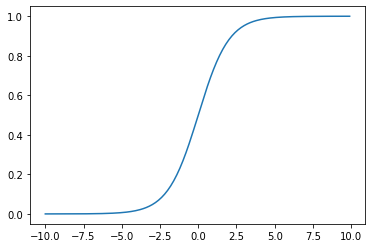

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


def sigmoid(x):
  return 1.0 / (1.0 + math.e**-x)

x = np.arange(-10, 10, 0.1)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

微分は0付近で大きな値となり、それ以外はほぼ0である。しかし、最大でも0.25の勾配しか得られない。
$$ f'(x) = f(x)\left( 1 - f(x)\right) $$

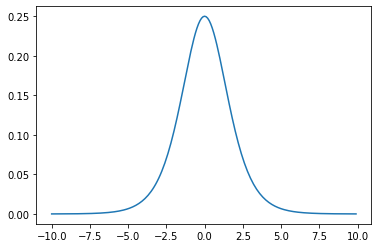

In [ ]:
def grad_sigmoid(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

y = grad_sigmoid(x)
plt.plot(x, y)
plt.show()

### tanh関数
出力が(-1.0, 1.0)に制限された関数である。
$$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

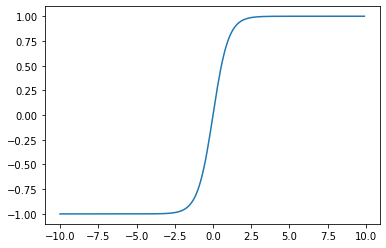

In [ ]:
y = np.tanh(x)
plt.plot(x, y)
plt.show()

微分はシグモイド関数と似ているが、最大値は0で1.0となっている。
$$ tanh'(x) = 1 - tanh^2(x) $$

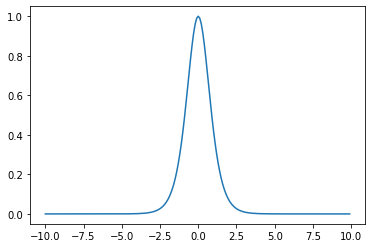

In [ ]:
y = 1 - np.tanh(x) ** 2
plt.plot(x, y)
plt.show()

### ReLU関数
入力が負の時は出力が0となり、正の場合はそのまま出力される関数である。
$$ f(x) = \max(0, x) $$

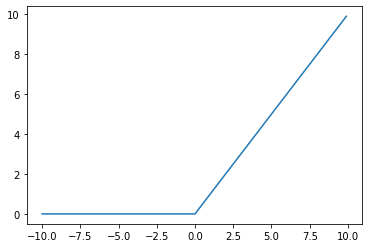

In [ ]:
y = np.maximum(0, x)
plt.plot(x, y)
plt.show()

微分は以下のようになる。つまり、入力が正の場合は1となる。したがって、ReLU関数を用いると出力がある場合、勾配は必ず1となりので、前出の活性化関数とは異なっている。
$$ f'(x) = \left\{\begin{array}{ll}1 & (x > 0) \\ 0 & (x \leq 0) \end{array} \right.$$

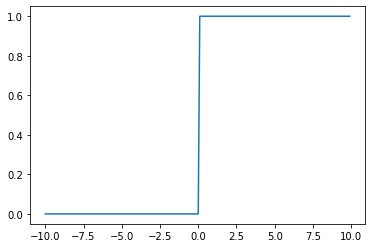

In [ ]:
def grad_relu(x):
  return np.where(x > 0, 1, 0)
  
y = grad_relu(x)
plt.plot(x, y)
plt.show()

### 恒等関数
入力層や出力層でニューロンの入力がそのまま出力となる場合の関数である。
$$ f(x) = x $$

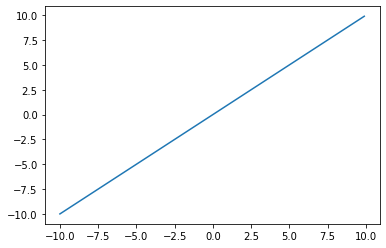

In [ ]:
y = x
plt.plot(x, y)
plt.show()

微分は入力に関係なく1である。
$$ f'(x) = 1 $$

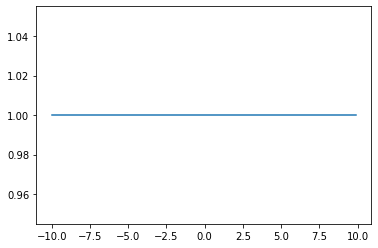

In [ ]:
def grad_identity(x):
  return np.ones(x.shape)

y = grad_identity(x)
plt.plot(x, y)
plt.show()

### ソフトマックス関数
多クラス分類の出力層でよく利用される活性化関数である。一般的にmax関数ではただ一つの出力のみが選ばれるが、ソフトマックス関数は値の差を強調して出力する関数である。また、出力の総和が1であることから、確率とみなすことも可能である。
$$ f_i(x) = \frac{e^{x_i}}{\sum_i e^{x_i}} $$

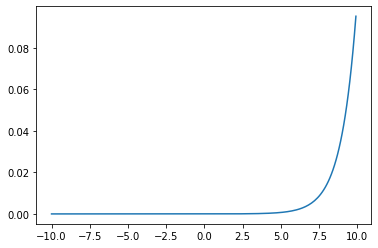

In [ ]:
def softmax(x):
  exp = np.exp(x)
  sum_exp = np.sum(exp)
  return exp/sum_exp

y = softmax(x)
plt.plot(x, y)
plt.show()

微分は以下のように定義される。
$$ \frac{\partial f_i(x)}{\partial x_j} = f_i(x)\left({\rm I}_{ij} - f_j(x)\right) $$

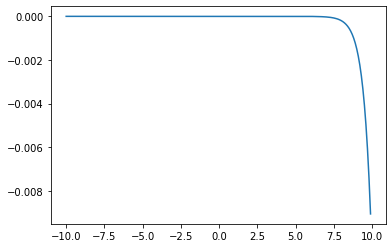

In [ ]:
def grad_softmax(x):
  y = softmax(x)
  tmp = np.zeros(y.shape)
  tmp[100] = 1.0
  return y * (tmp - y)

y = grad_softmax(x)
plt.plot(x, y)
plt.show()

## 最適化
Neural Networkの学習には誤差逆伝播法(Backpropagation)が用いられる。誤差逆伝播法は誤差関数c(x)の結合荷重に対する勾配を用いて修正を行う手法である。
$$ {\rm W} = {\rm W} - \epsilon \frac{\partial c(x)}{\partial {\rm W}} $$
上記の修正は最急降下法と呼ばれ、PyTorchではtorch.optim.SGD()で利用することができる。
以下では、εを学習率と呼ぶこととする。

### 最急降下法
最小値(極値)では、勾配が0になることは自明である。したがって、最適化では勾配が0となる箇所を見つけることが目標である。

ここで、以下のような簡単な問題を考えてみよう。
$$ x^2 = 2 $$
このxを求めるには、$$ x^2 -2$$が0となるxを見つける必要がある。
今、適当な値zを式に代入して0となればそれが答えであり、正であればzを小さくし、負であればzを大きくすればいつか答えが見つかると思われる。このアイデアをそのままプログラムにして確認してみる。


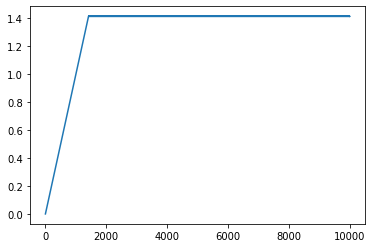

In [ ]:
def f(x):
  return x**2 - 2.0

x = 0.0
epsilon = 0.001
history = [0.0]
for i in range(10000):
  if f(x) > 0:
    x -= epsilon
  else:
    x += epsilon
  history.append(x)

epochs = np.arange(10001)
history = np.array(history, dtype=np.float32)
plt.plot(epochs, history)
plt.show()


この実験では、1.414に近づいている。つまり、関数が0となる位置を探したいのであれば、適当な値でのその関数を符号に応じて値を増減させればいい。

今、0にしたい関数は勾配であるため、適当なxに対する勾配の値の符号に応じてxの増減を決めればよい。したがって、勾配の値が正の時はズレを小さくしたいので減らせばよく、負の場合は大きくすれば良いので増やせばよい。修正量も勾配の大きさに応じたものすれのであれば、修正量は
$$ -\epsilon \frac{\partial c(x)}{\partial {\rm W}} $$
で決めることは妥当であることが分かる。

これが最急降下法と呼ばれる手法である。勾配は値xでの接線の傾きを表しているので、その傾きの向きが一番早く値を変化させることができる向きである。よって、一番値を変化させられる方向に修正をするため、最急降下法と呼ばれる所以である。

以下の関数の最小値を最急降下法を用いて計算する。
$$ 2x^2 + 3x + 1 $$

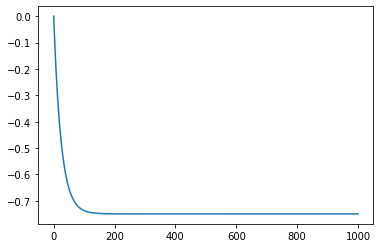

In [ ]:
def grad(x):
  return 4 * x + 3

epsilon = 0.01
z = 0
history = [0]
for i in range(1000):
  g = grad(z)
  z -= epsilon * g
  history.append(z)

epoch = np.arange(1001)
history = np.array(history, dtype=np.float32)
plt.plot(epoch, history)
plt.show()


基本的にはニューラルネットワークの学習も同じような手順で進むこととなる。

### (例題)パリティビット
入力されたビット列に対して偶数パリティを予測する多層パーセプトロンを作成してみる。まず、3層ニューラルネットワークで実装する。学習に関しては、最急降下法を用いる。学習率は0.1とする。

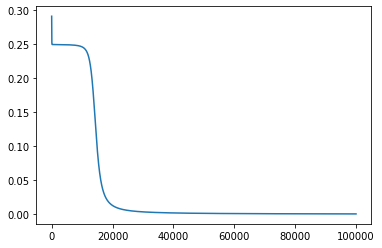

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    h = torch.sigmoid(self.l1(x))
    return torch.sigmoid(self.l2(h))

x = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]], dtype=torch.float)
y = torch.tensor([[0], [1], [1], [0], [1], [0], [0], [1]], dtype=torch.float)

model = MLP(3, 3, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-1)
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()

一時的に、0.25付近で留まったが、最終的には0に到達している。
学習率はパラメータの修正量に影響を及ぼすので、適当な値を決めなくてはならない。例えば、小さい値にしすぎるとなかなか収束しないし、大きな値にするとうまく収束できなくなる。
まず、学習率を先ほどの1/100である0.001にしてみよう。

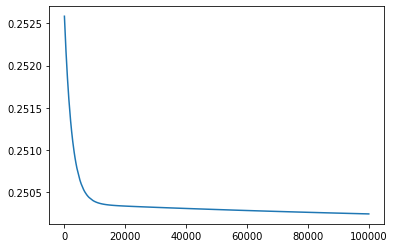

In [ ]:
model = MLP(3, 3, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3)
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()

0.1を利用した時に比べて100000回の学習後でも誤差が0.25で留まってしまっている。これは十分に学習が行えているとは言えない状況である。
では、さらに大きな学習率を用いた場合を考える。ここでは、学習率を100として実験を行う。

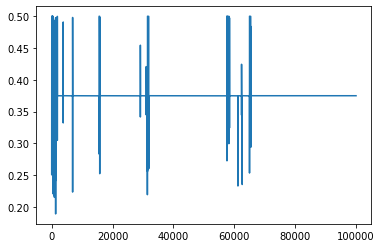

In [ ]:
model = MLP(3, 3, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=100)
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()

今度は誤差が振動してしまっている。このため、学習が行えていない。これは、修正量が大きくなりすぎて、最適値に到達できないためと考えられる。
このように小さすぎる学習率ではなかなか誤差が小さくならず、大きすぎる学習率では最適値を超えてしまう。
これより、最急降下法では適切な誤差を選択することが重要であることがわかる。

### ADAM
最急降下法では適切な学習率を決定することが重要であることがわかった。したがって、この学習率に対応する値を適応的に決定することができれば良いと考えられる。そのようなアイデアに基づいた最適化手法がADAMである。PyTorchではtorch.optim.Adam()として実装されている。では、ADAMを用いて3層ニューラルネットワークを学習しよう。

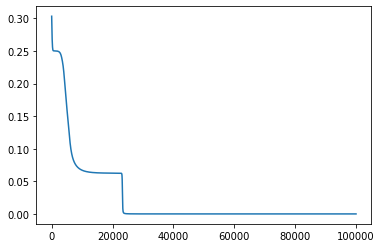

In [ ]:
model = MLP(3, 3, 1)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()

ADAMを使った場合には、パラメータの調整をしなくても滑らかに、かつ高速に最適値に到達していることがわかる。
どのような学習方法を用いるのが良いかは議論の余地があるので、実際に利用する際には比較実験を行なってもらいたい。

## 3層以上のニューラルネットワーク
ここでは、Deep Learningっぽく3層以上のニューラルネットワークを用いてパリティビットを予測しよう。5層ニューラルネットワークを構築する。
PyTorchなどのDeep Learning Frameworkを用いることで、簡単に多層のニューラルネットワークを高築することができることが分かる。

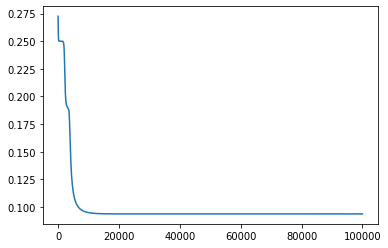

In [ ]:
class MLP5(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP5, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, hidden_size)
    self.l4 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h1 = torch.sigmoid(self.l1(x))
    h2 = torch.sigmoid(self.l2(h1))
    h3 = torch.sigmoid(self.l3(h2))
    return torch.sigmoid(self.l4(h3))

model = MLP5(3, 3, 1)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()

誤差は0に収束しておらず、3層ニューラルネットワークと比べると、途中で停留する部分があることが分かる。これは、ニューラルネットワークが複雑になりすぎたため、いくつかの局所最適値が現れてきたためと考えられる。では、結合荷重の修正量に影響を及ぼす勾配について検討してみよう。各層での最大の勾配を表示してみる。

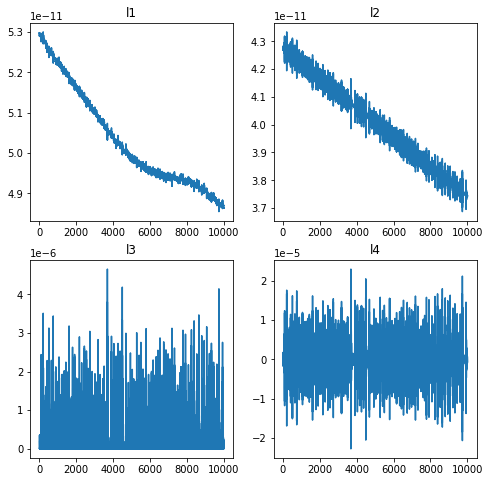

In [ ]:
history_l1 = []
history_l2 = []
history_l3 = []
history_l4 = []
max_epoch = 10000
params = list(model.parameters())
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  model.zero_grad()
  error.backward()
  history_l1.append(torch.max(params[0].grad).data)
  history_l2.append(torch.max(params[2].grad).data)
  history_l3.append(torch.max(params[4].grad).data)
  history_l4.append(torch.max(params[6].grad).data)
  optimizer.step()

history_l1 = np.array(history_l1, dtype=np.float32)
history_l2 = np.array(history_l2, dtype=np.float32)
history_l3 = np.array(history_l3, dtype=np.float32)
history_l4 = np.array(history_l4, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].plot(epochs, history_l1)
axes[0,0].set_title('l1')
axes[0,1].plot(epochs, history_l2)
axes[0,1].set_title('l2')
axes[1,0].plot(epochs, history_l3)
axes[1,0].set_title('l3')
axes[1,1].plot(epochs, history_l4)
axes[1,1].set_title('l4')
plt.show()

入力層に近いほど勾配の大きさが小さいことがわかる。これは、全結合層をただ積み重ねていくだけでは、深い層の勾配が非常に小さくなってしまい、結合荷重の修正があまり進まないということである。一般的に、勾配消失と呼ばれるDeep Learningで問題となる現象である。これは、各層ごとに活性化関数が含まれており、誤差が層を通過して前の層に戻すときに、活性化関数の微分がかけられるのが一因である。

では、活性化関数がない場合について考えてみる。活性化関数がないため、このニューラルネットワークは単純な線形変換であるため、誤差関数は0には近づいていない。

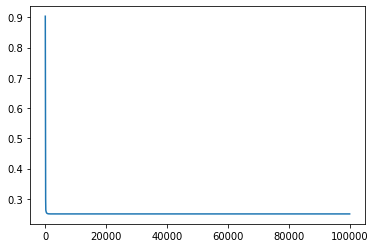

In [ ]:
class MLP5l(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP5l, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, hidden_size)
    self.l3 = nn.Linear(hidden_size, hidden_size)
    self.l4 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h1 = self.l1(x)
    h2 = self.l2(h1)
    h3 = self.l3(h2)
    return self.l4(h3)

model = MLP5l(3, 3, 1)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()


では、この場合の各層の勾配を表示してみる。

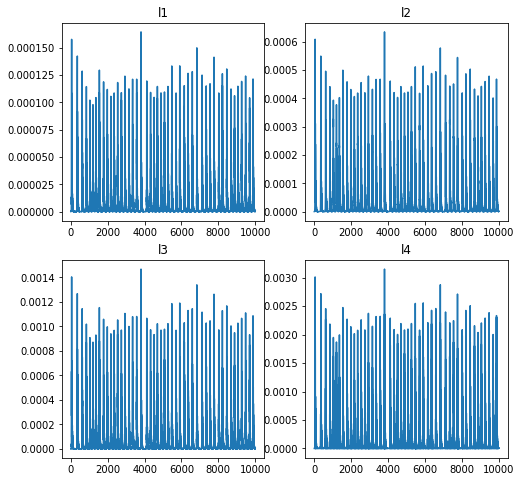

In [ ]:
history_l1 = []
history_l2 = []
history_l3 = []
history_l4 = []
max_epoch = 10000
params = list(model.parameters())
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  model.zero_grad()
  error.backward()
  history_l1.append(torch.max(params[0].grad).data)
  history_l2.append(torch.max(params[2].grad).data)
  history_l3.append(torch.max(params[4].grad).data)
  history_l4.append(torch.max(params[6].grad).data)
  optimizer.step()

history_l1 = np.array(history_l1, dtype=np.float32)
history_l2 = np.array(history_l2, dtype=np.float32)
history_l3 = np.array(history_l3, dtype=np.float32)
history_l4 = np.array(history_l4, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes[0,0].plot(epochs, history_l1)
axes[0,0].set_title('l1')
axes[0,1].plot(epochs, history_l2)
axes[0,1].set_title('l2')
axes[1,0].plot(epochs, history_l3)
axes[1,0].set_title('l3')
axes[1,1].plot(epochs, history_l4)
axes[1,1].set_title('l4')
plt.show()

この結果をみると、活性化関数を用いなくても深い層の勾配は小さくなっているが、先ほどの場合に比べて現象は穏やかである。これは、結合荷重は平均0のガウス分布で初期化されるため、非常に小さな値を持っていることが一因である。したがって、活性化関数と結合荷重を複数積み重ねることによって深い層の勾配が急激に小さくなる。

## 課題
XOR問題に対して、上記のように学習率を変えたときの学習の変化についてまとめなさい。

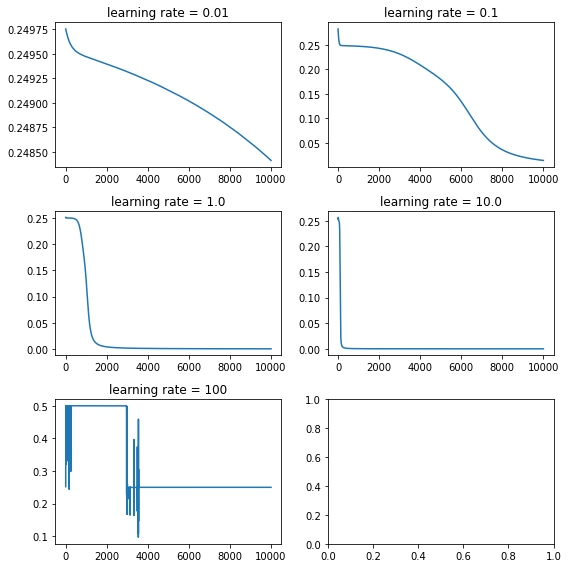

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()

    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h = torch.sigmoid(self.l1(x))
    o = torch.sigmoid(self.l2(h))
    return o

x = torch.tensor([[0.,0.], [0.,1.], [1.,0.], [1.,1.]])
y = torch.tensor([[0.], [1.], [1.], [0.]])

criterion = nn.MSELoss()
max_epoch = 10000

model001 = MLP(2, 3, 1)
optimizer = torch.optim.SGD(model001.parameters(), lr=0.01)
history_001 = []
for epoch in range(max_epoch):
  pred = model001(x)
  error = criterion(pred, y)
  history_001.append(error.item())
  optimizer.zero_grad()
  error.backward()
  optimizer.step()

model01 = MLP(2, 3, 1)
optimizer = torch.optim.SGD(model01.parameters(), lr=0.1)
history_01 = []
for epoch in range(max_epoch):
  pred = model01(x)
  error = criterion(pred, y)
  history_01.append(error.item())
  optimizer.zero_grad()
  error.backward()
  optimizer.step()

model1 = MLP(2, 3, 1)
optimizer = torch.optim.SGD(model1.parameters(), lr=1.0)
history_1 = []
for epoch in range(max_epoch):
  pred = model1(x)
  error = criterion(pred, y)
  history_1.append(error.item())
  optimizer.zero_grad()
  error.backward()
  optimizer.step()

model10 = MLP(2, 3, 1)
optimizer = torch.optim.SGD(model10.parameters(), lr=10.0)
history_10 = []
for epoch in range(max_epoch):
  pred = model10(x)
  error = criterion(pred, y)
  history_10.append(error.item())
  optimizer.zero_grad()
  error.backward()
  optimizer.step()

model100 = MLP(2, 3, 1)
optimizer = torch.optim.SGD(model100.parameters(), lr=100.0)
history_100 = []
for epoch in range(max_epoch):
  pred = model100(x)
  error = criterion(pred, y)
  history_100.append(error.item())
  optimizer.zero_grad()
  error.backward()
  optimizer.step()

history_001 = np.array(history_001, dtype=np.float32)
history_01 = np.array(history_01, dtype=np.float32)
history_1 = np.array(history_1, dtype=np.float32)
history_10 = np.array(history_10, dtype=np.float32)
history_100 = np.array(history_100, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
axes[0,0].plot(epochs, history_001)
axes[0,0].set_title('learning rate = 0.01')
axes[0,1].plot(epochs, history_01)
axes[0,1].set_title('learning rate = 0.1')
axes[1,0].plot(epochs, history_1)
axes[1,0].set_title('learning rate = 1.0')
axes[1,1].plot(epochs, history_10)
axes[1,1].set_title('learning rate = 10.0')
axes[2,0].plot(epochs, history_100)
axes[2,0].set_title('learning rate = 100')
plt.tight_layout()
plt.show()


## （課題解答）XOR問題で学習率を変えたときの変化
　上の図は、学習率を0.01, 0.1, 1.0, 10.0, 100.0のときのepoch(横軸)と真値との平均2乗誤差(縦軸)の関係を表すグラフである。

　0.01のときは、誤差0.25あたりで学習が停滞してしまっている。

　0.1のときは、8000回目あたりで誤差0.25の停滞を突破できているが、まだ学習が必要そうで、効率が良いとは言えない。

　1.0のときは、2000回目手前あたりで誤差がほぼ0になっていて、学習がうまくできている。

　10.0のときは、1.0のときよりもかなり早く誤差がほぼ0になっており、この中で最もうまくできた学習率であると言える。

　100.0のときは、誤差が振動したり0.5あたりで停滞したりして全く学習がうまくできておらず、学習率が大きすぎると考えられる。
　

## GPUの使い方
Google ColaboratoyではPyTorchでの学習をGPUを用いて実行することができる。最後に、GPUを使う方法について説明する。
以下のコードを実行する際には、「ランタイム」-「ランタイムのタイプの変更」でGPUを指定してください。

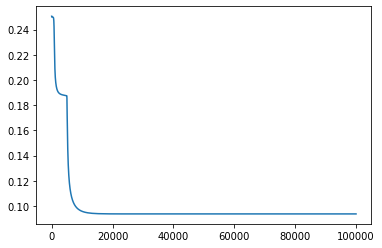

In [ ]:
device = torch.device('cuda:0')
x = x.to(device)
y = y.to(device)
model = MLP5(3, 3, 1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
max_epoch = 100000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(y, pred)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()

## 誤差関数
ニューラルネットワークを学習するためには誤差関数を定義し、最小化する必要がある。よく使われる誤差関数を紹介する。
### 平均二乗誤差
以下の式で定義される誤差関数。
$$ \frac{1}{N}\sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 $$
PyTorchではtorch.nnMSELoss()で定義されている。
### 交差エントロピー
ニューラルネットワークの出力が確率分布とみなせる時、目的の確率分布との差を評価する誤差関数。出力層がSoftmax関数を活性化関数としている場合などに用いられる。
$$ -\sum_{i=1}^K \left\{y_{ni}\ln \hat{y}_{ni} + (1-y_{ni}) \ln (1 - \hat{y}_{ni}) \right\} $$
PyTorchではtorch.nn.CrossEntropyLoss()として定義されており、softmax関数が組み込まれている点に注意する必要がある。

## 課題
パリティビットを予測する3層ニューラルネットワークの出力を2つにし、交差エントロピーを誤差関数とした場合のプログラムを作成しなさい。torch.nn.CrossEntropyLoss()の使い方についてはWeb上で調べること。

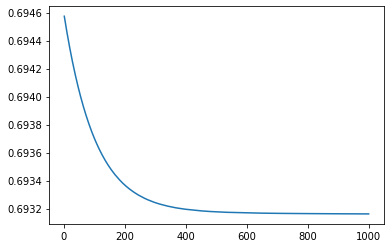

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.l2 = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    h = torch.sigmoid(self.l1(x))
    return torch.sigmoid(self.l2(h))

x = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]], dtype=torch.float)
y = torch.tensor([0, 1, 1, 0, 1, 0, 0, 1], dtype=torch.long)

model = MLP(3, 3, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-1)
criterion = nn.CrossEntropyLoss()

history = []
max_epoch = 1000
for epoch in range(max_epoch):
  pred = model(x)
  error = criterion(pred, y)
  history.append(error.item())
  model.zero_grad()
  error.backward()
  optimizer.step()

history = np.array(history, dtype=np.float32)
epochs = np.arange(1, max_epoch+1)
plt.plot(epochs, history)
plt.show()